# Documenting my thought process
Looking things over, genus and skeletal material have a 1-to-1 correlation, with the exception of 11 entries (and 14 entries where skeletal material is null). However, because the dataset is really imbalanced, the standard random forest model can only achieve a maximum of about 98% accuracy (about 130-150 incorrect predictions out of about 6300 testing samples). So here's the plan: make a lookup table based on genus that maps to a skeletal material. For new entries, if the genus is in the lookup table, just use that mapping. If it isn't, fall back on a model that doesn't use genus to make predictions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
#import seaborn as sns
import joblib
import json

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score as f2
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier as RFC
datapath = "C:\Users\meredithc\OneDrive - Milwaukee School of Engineering\Projects\CS3310\cordie-lab\cordie_data_modified.xlsx"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_df = pd.read_excel(datapath, sheet_name=0, header=21)

main_df = pd.read_excel(datapath, sheet_name=1, header=0)
main_df = main_df[["occurrence_no", "Skeletal Material", "Bin Interval"]]

merged_df = raw_df.merge(main_df, left_on="occurrence_no", right_on="occurrence_no")
#merged_df.set_index("occurrence_no", inplace=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25192 entries, 0 to 25191
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   occurrence_no      25192 non-null  int64  
 1   record_type        25192 non-null  object 
 2   reid_no            109 non-null    float64
 3   flags              0 non-null      float64
 4   collection_no      25192 non-null  int64  
 5   accepted_name      25192 non-null  object 
 6   accepted_rank      25192 non-null  object 
 7   accepted_no        25192 non-null  int64  
 8   early_interval     25192 non-null  object 
 9   late_interval      1468 non-null   object 
 10  max_ma             25192 non-null  float64
 11  min_ma             25192 non-null  float64
 12  ref_author         25192 non-null  object 
 13  ref_pubyr          25192 non-null  int64  
 14  reference_no       25192 non-null  int64  
 15  phylum             25192 non-null  object 
 16  class              251

In [4]:
genus_df = merged_df[["occurrence_no", "genus", "Skeletal Material"]].dropna()
genus_df["Skeletal Material"].replace("oragnic", "organic", inplace=True)

In [5]:
mappings = {}
mismatches = {}

for index, row in genus_df.iterrows():
    if row["genus"] not in mappings.keys():
        mappings[row["genus"]] = row["Skeletal Material"]
    elif row["genus"] in mappings.keys():
        if mappings[row["genus"]] != row["Skeletal Material"]:
            print("Mismatch found.")
            mismatches[row["occurrence_no"]] = {
                "genus": row["genus"],
                "found": row["Skeletal Material"],
                "expected": mappings[row["genus"]]
            }

Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.
Mismatch found.


In [6]:
mappings

{'Bonniopsis': 'low-Mg calcite',
 'Mesonacis': 'low-Mg calcite',
 'Paterina': 'low-Mg calcite',
 'Hyolithes': 'phosphate',
 'Antagmus': 'low-Mg calcite',
 'Olenellus': 'low-Mg calcite',
 'Nisusia': 'low-Mg calcite',
 'Agraulos': 'low-Mg calcite',
 'Bonnia': 'low-Mg calcite',
 'Crassifimbra': 'low-Mg calcite',
 'Onchocephalus': 'low-Mg calcite',
 'Pagetia': 'low-Mg calcite',
 'Piaziella': 'low-Mg calcite',
 'Ptychoparella': 'low-Mg calcite',
 'Zacanthopsis': 'low-Mg calcite',
 'Acrothele': 'phosphate',
 'Acrotreta': 'phosphate',
 'Dictyonina': 'low-Mg calcite',
 'Amecephalus': 'low-Mg calcite',
 'Chancia': 'low-Mg calcite',
 'Ogygopsis': 'low-Mg calcite',
 'Oryctocephalus': 'low-Mg calcite',
 'Poliella': 'low-Mg calcite',
 'Stephenaspis': 'low-Mg calcite',
 'Wenkchemnia': 'low-Mg calcite',
 'Alokistocare': 'low-Mg calcite',
 'Alokistocarella': 'low-Mg calcite',
 'Bathyuriscus': 'low-Mg calcite',
 'Clavaspidella': 'low-Mg calcite',
 'Dolichometopsis': 'low-Mg calcite',
 'Ehmaniella': 'lo

In [7]:
mismatches.keys()

dict_keys([1739, 800217, 800240, 801037, 801146, 801236, 801314, 801530, 1358154, 1378753, 1378767])

In [8]:
mismatches

{1739: {'genus': 'Modocia', 'found': 'silica', 'expected': 'low-Mg calcite'},
 800217: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 800240: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 801037: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 801146: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 801236: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 801314: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 801530: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 1358154: {'genus': 'Amsassia',
  'found': 'silica',
  'expected': 'high-Mg calcite'},
 1378753: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'},
 1378767: {'genus': 'Alalcomenaeus',
  'found': 'phosphate',
  'expected': 'organic'}}

In [9]:
for k in mismatches.keys():
    genus_df = genus_df[genus_df["occurrence_no"] != k]

In [10]:
mappings = {}
mismatches = {}

for index, row in genus_df.iterrows():
    if row["genus"] not in mappings.keys():
        mappings[row["genus"]] = row["Skeletal Material"]
    elif row["genus"] in mappings.keys():
        if mappings[row["genus"]] != row["Skeletal Material"]:
            print("Mismatch found.")
            mismatches[row["occurrence_no"]] = {
                "genus": row["genus"],
                "found": row["Skeletal Material"],
                "expected": mappings[row["genus"]]
            }
            
#export mappings to json

In [11]:
with open("skeletal_material_map.json", "w") as fp:
    json.dump(mappings, fp)

In [12]:
len(mismatches.keys())

0

In [13]:
cleaned_df = merged_df.filter(["occurrence_no", "early_interval", "max_ma", "min_ma", "phylum", "class", "order", "family", "genus", "cc", "paleolng", "paleolat", "geoplate", "Skeletal Material", "Bin Interval"])
cat_cols = ["early_interval", "phylum", "class", "order", "family", "genus", "cc", "geoplate", "Skeletal Material", "Bin Interval"]
num_cols = ["max_ma", "min_ma", "paleolng", "paleolat"]
cleaned_df["Skeletal Material"].replace("oragnic", "organic", inplace=True)

cleaned_df["Bin Interval"].replace("Jiangshangian ", "Jiangshanian", inplace=True)
cleaned_df["Bin Interval"].replace("Piabian", "Paibian", inplace=True)
#remove stage 3
cleaned_df = cleaned_df[cleaned_df["Bin Interval"] != "Stage 3"]

In [14]:
cleaned_df["Skeletal Material"].value_counts()

low-Mg calcite                 18102
phosphate                       3793
aragonite                        947
high-Mg calcite                  937
organic                          915
silica                           437
high- and/or low-Mg calcite       40
Name: Skeletal Material, dtype: int64

In [15]:
cleaned_df["Bin Interval"].value_counts()

Tremadocian     6698
Guzhangian      3997
Jiangshanian    3873
Drumian         3222
Wuliuan         2846
Stage 10        2099
Paibian         1796
Stage 4          316
Name: Bin Interval, dtype: int64

In [16]:
cleaned_df["Bin Interval"].isna().sum()

343

In [17]:
cleaned_df["Skeletal Material"].isna().sum()

19

In [18]:
df = cleaned_df.dropna()
df.set_index("occurrence_no", inplace=True)

#encoding categorical columns
#note: label_encoding is a dict of dicts, where each sub-dict has the label encodings as keys and the actual names as values
#for example, label_encoding["accepted_name_x"][0] returns the accepted_name_x that is encoded as 0
label_encoding = {}
le = preprocessing.LabelEncoder()

for col in cat_cols:
    le.fit(df[col])
    df[col] = le.transform(df[col])
    temp_encoding = dict(zip(le.classes_, le.transform(le.classes_)))
    label_encoding[col] = {str(v): k for k, v in temp_encoding.items()}
    df[col] = df[col].astype("int64")

#just making sure the numerical columns are all floats
for col in num_cols:
    df[col] = df[col].astype("float64")

In [19]:
df.head()

,early_interval,max_ma,min_ma,phylum,class,order,family,genus,cc,paleolng,paleolat,geoplate,Skeletal Material,Bin Interval
occurrence_no,,,,,,,,,,,,,,
1251,6,541.0,485.4,2,62,36,147,289,5,-86.74,30.34,4,3,5
1252,6,541.0,485.4,2,62,122,303,1267,5,-86.74,30.34,4,3,5
1254,6,541.0,485.4,3,43,102,329,1582,5,-86.74,30.34,4,3,5
1255,6,541.0,485.4,12,36,65,217,928,5,-86.74,30.34,4,5,5
1262,6,541.0,485.4,2,62,86,29,136,34,-139.72,29.26,0,3,7


In [20]:
with open("label_and_feature_encodings.json", "w") as fp:
    json.dump(label_encoding, fp)

# Skeletal Material

In [21]:
sm_df_train, sm_df_test = train_test_split(df.drop(columns=["Bin Interval"]), stratify=df["Skeletal Material"])
sm_y_train = sm_df_train["Skeletal Material"]
sm_y_test = sm_df_test["Skeletal Material"]
sm_X_train = sm_df_train.drop(columns=["genus","Skeletal Material"])
sm_X_test = sm_df_test.drop(columns=["genus","Skeletal Material"])

In [22]:
sm_model = RFC(n_estimators=25, max_depth=40)
sm_model.fit(sm_X_train, sm_y_train)

RandomForestClassifier(max_depth=40, n_estimators=25)

In [23]:
sm_pred_labels = sm_model.predict(sm_X_test)
sm_pred_prob = sm_model.predict_proba(sm_X_test)

In [24]:
sm_model_accuracy = accuracy_score(sm_y_test, sm_pred_labels)
sm_model_f1 = f1(sm_y_test, sm_pred_labels, average="macro")
sm_model_precision = precision_score(sm_y_test, sm_pred_labels, average="macro")
sm_model_recall = recall_score(sm_y_test, sm_pred_labels, average="macro")
print("Skeletal Material model accuracy:", sm_model_accuracy)
print("Skeletal Material model F1-score:", sm_model_f1)
print("Skeletal Material model precision:", sm_model_precision)
print("Skeletal Material model recall:", sm_model_recall)

Skeletal Material model accuracy: 0.9930020993701889
Skeletal Material model F1-score: 0.9816038928313097
Skeletal Material model precision: 0.9822981909563807
Skeletal Material model recall: 0.9809699223387189


In [25]:
np.count_nonzero(np.isnan(sm_pred_prob))

0

In [26]:
sm_cfm = confusion_matrix(sm_y_test, sm_pred_labels)

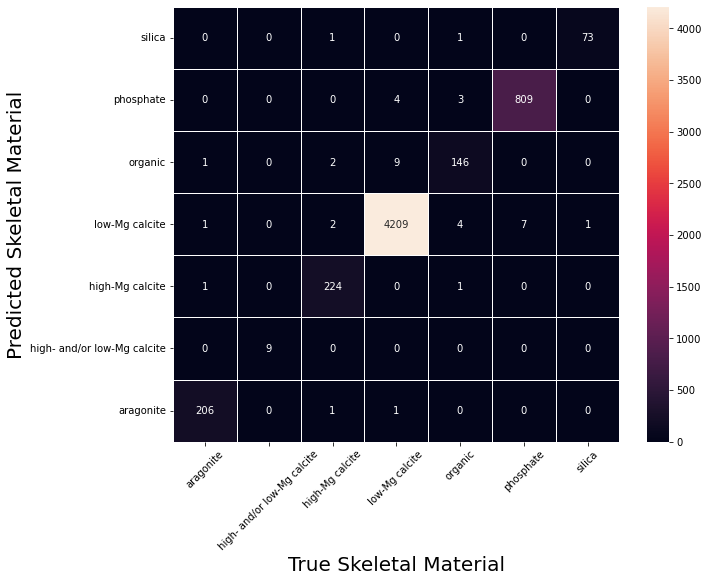

In [27]:
plt.figure(figsize=(10,8))
#switch axes
ax = sns.heatmap(sm_cfm, annot=True, linewidth=.5, fmt="", xticklabels=label_encoding["Skeletal Material"].values(), yticklabels=label_encoding["Skeletal Material"].values())
ax.invert_yaxis()
ax.set_ylabel("Predicted Skeletal Material", fontsize=20)
ax.set_xlabel("True Skeletal Material", fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [28]:
sm_importances = sm_model.feature_importances_ 

<function matplotlib.pyplot.show(close=None, block=None)>

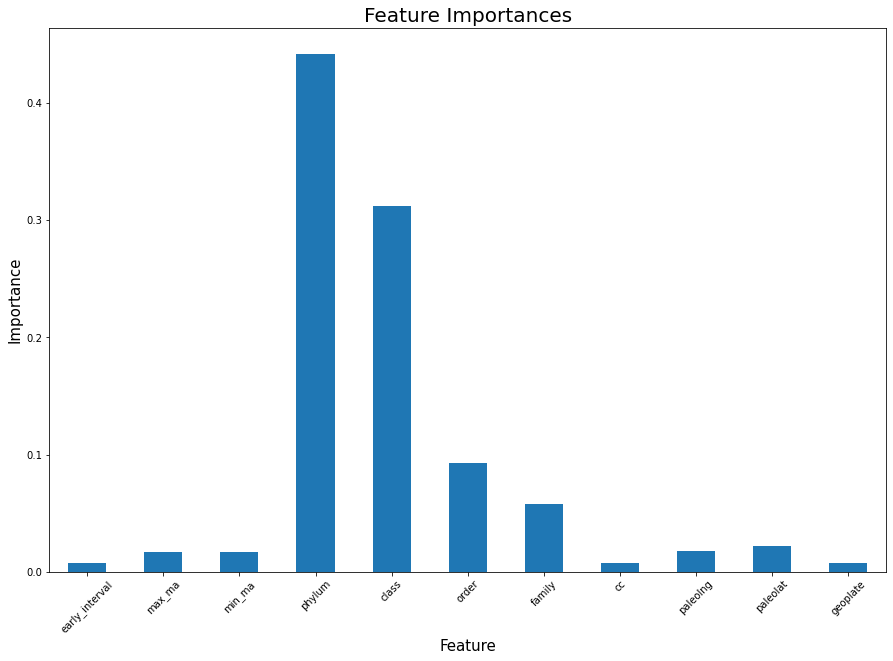

In [29]:
sm_rfc_importances = pd.Series(sm_importances, index=sm_X_train.columns)
plt.figure(figsize=(15,10))
sm_rfc_importances.plot.bar()
plt.title("Feature Importances", fontsize=20)
plt.xlabel("Feature", fontsize=15)
plt.ylabel("Importance", fontsize=15)
plt.xticks(rotation=45)
plt.show

In [30]:
sm_roc_curves = [0] * (len(np.unique(sm_y_test)))
sm_accuracy_scores = [0] * (len(np.unique(sm_y_test)))
for c in np.unique(sm_y_test):
    temp1 = [0 if c_ != c else 1 for c_ in sm_y_test]
    temp2 = [0 if c_ != c else 1 for c_ in sm_pred_labels]
    temp_prob = sm_pred_prob[:, c]
    fpr, tpr, _ = roc_curve(temp1, temp_prob)
    sm_roc_curves[c] = (fpr, tpr)
    sm_accuracy_scores[c] = accuracy_score(temp1, temp2)

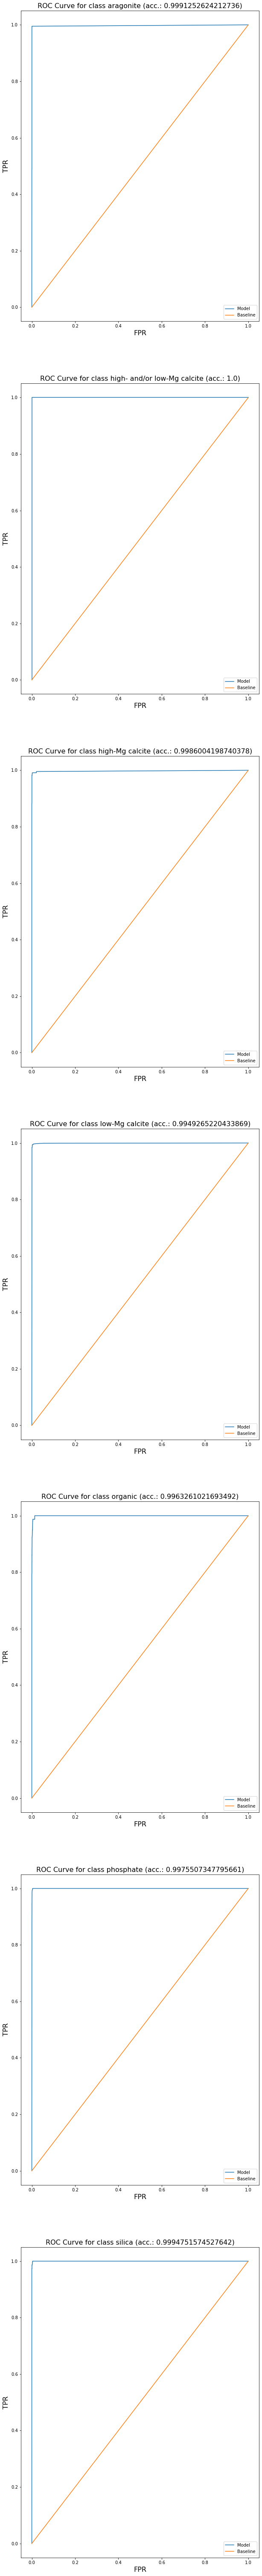

In [31]:
sm_roc_fig, sm_roc_ax = plt.subplots(len(sm_roc_curves),1, figsize=[10, 110])
for c in range(len(sm_roc_curves)):
    sm_roc_ax[c].plot(sm_roc_curves[c][0], sm_roc_curves[c][1], label="Model")
    sm_roc_ax[c].plot([0.0, 1.0], [0.0, 1.0], label="Baseline")
    sm_roc_ax[c].set_xlabel("FPR", fontsize=16)
    sm_roc_ax[c].set_ylabel("TPR", fontsize=16)
    t = "ROC Curve for class " + str(label_encoding["Skeletal Material"][str(c)]) + " (acc.: " + str(sm_accuracy_scores[c]) + ")"
    sm_roc_ax[c].set_title(t, fontsize=16)
    sm_roc_ax[c].legend()
    
plt.show()

In [32]:
joblib.dump(sm_model, "skeletal_material_model.joblib")

['skeletal_material_model.joblib']

# Bin Interval Model

In [33]:
bi_df_train, bi_df_test = train_test_split(df.drop(columns=["Skeletal Material"]), stratify=df["Bin Interval"])
bi_y_train = bi_df_train["Bin Interval"]
bi_y_test = bi_df_test["Bin Interval"]
bi_X_train = bi_df_train.drop(columns=["Bin Interval"])
bi_X_test = bi_df_test.drop(columns=["Bin Interval"])

In [34]:
bi_model = RFC(n_estimators=25, max_depth=40)
bi_model.fit(bi_X_train, bi_y_train)

RandomForestClassifier(max_depth=40, n_estimators=25)

In [35]:
bi_pred_labels = bi_model.predict(bi_X_test)
bi_pred_prob = bi_model.predict_proba(bi_X_test)

In [36]:
bi_model_accuracy = accuracy_score(bi_y_test, bi_pred_labels)
bi_model_f1 = f1(bi_y_test, bi_pred_labels, average="macro")
bi_model_precision = precision_score(bi_y_test, bi_pred_labels, average="macro")
bi_model_recall = recall_score(bi_y_test, bi_pred_labels, average="macro")
print("Bin Interval model accuracy:", bi_model_accuracy)
print("Bin Interval model F1-score:", bi_model_f1)
print("Bin Interval model precision:", bi_model_precision)
print("Bin Interval model recall:", bi_model_recall)

Bin Interval model accuracy: 0.962036389083275
Bin Interval model F1-score: 0.9317038376989528
Bin Interval model precision: 0.934688621744495
Bin Interval model recall: 0.9294119857390731


In [37]:
np.count_nonzero(np.isnan(bi_pred_prob))

0

In [38]:
bi_cfm = confusion_matrix(bi_y_test, bi_pred_labels)

In [39]:
label_encoding["Bin Interval"]

{'0': 'Drumian',
 '1': 'Guzhangian',
 '2': 'Jiangshanian',
 '3': 'Paibian',
 '4': 'Stage 10',
 '5': 'Stage 4',
 '6': 'Tremadocian',
 '7': 'Wuliuan'}

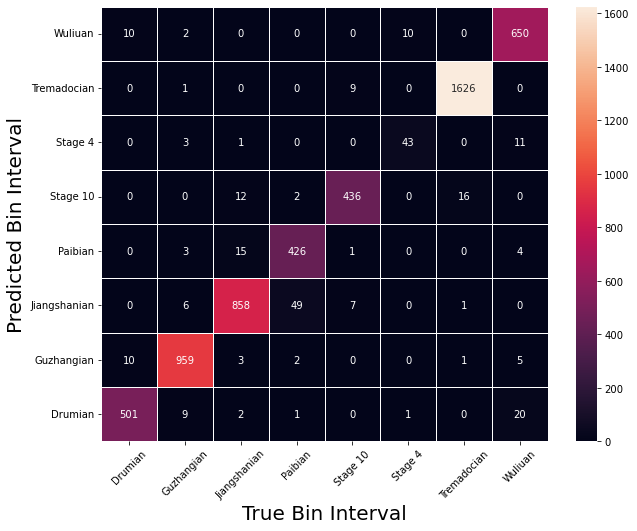

In [40]:
plt.figure(figsize=(10,8))
#switch axes
ax = sns.heatmap(bi_cfm, annot=True, linewidth=.5, fmt="", xticklabels=label_encoding["Bin Interval"].values(), yticklabels=label_encoding["Bin Interval"].values())
ax.invert_yaxis()
ax.set_ylabel("Predicted Bin Interval", fontsize=20)
ax.set_xlabel("True Bin Interval", fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [41]:
bi_importances = bi_model.feature_importances_ 

<function matplotlib.pyplot.show(close=None, block=None)>

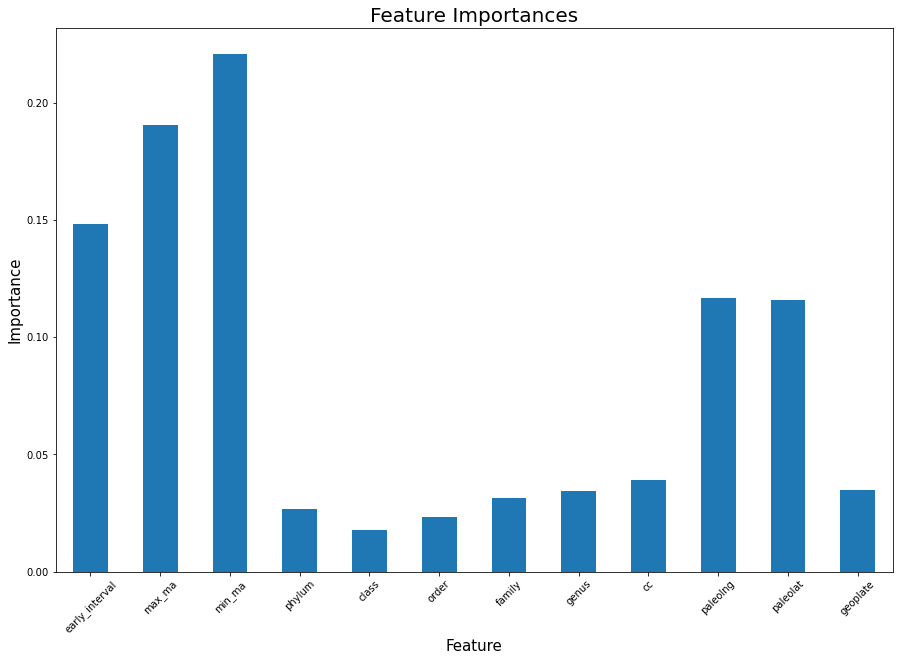

In [42]:
bi_rfc_importances = pd.Series(bi_importances, index=bi_X_train.columns)
plt.figure(figsize=(15,10))
bi_rfc_importances.plot.bar()
plt.title("Feature Importances", fontsize=20)
plt.xlabel("Feature", fontsize=15)
plt.ylabel("Importance", fontsize=15)
plt.xticks(rotation=45)
plt.show

In [43]:
bi_roc_curves = [0] * (len(np.unique(bi_y_test)))
bi_accuracy_scores = [0] * (len(np.unique(bi_y_test)))
for c in np.unique(bi_y_test):
    temp1 = [0 if c_ != c else 1 for c_ in bi_y_test]
    temp2 = [0 if c_ != c else 1 for c_ in bi_pred_labels]
    temp_prob = bi_pred_prob[:, c]
    fpr, tpr, _ = roc_curve(temp1, temp_prob)
    bi_roc_curves[c] = (fpr, tpr)
    bi_accuracy_scores[c] = accuracy_score(temp1, temp2)

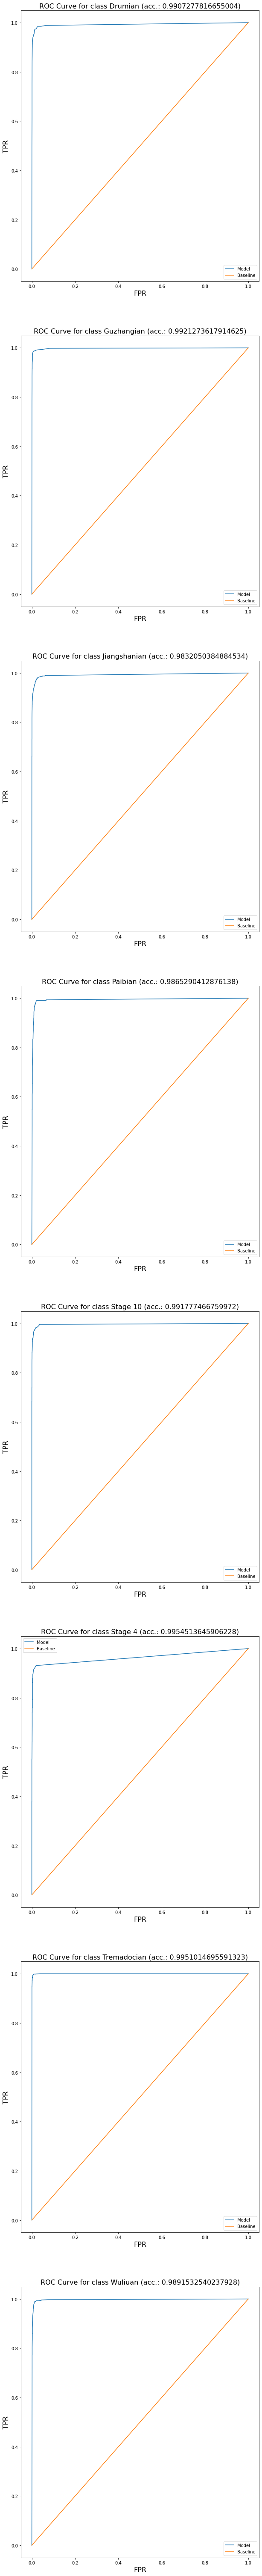

In [44]:
bi_roc_fig, bi_roc_ax = plt.subplots(len(bi_roc_curves),1, figsize=[10, 110])
for c in range(len(bi_roc_curves)):
    bi_roc_ax[c].plot(bi_roc_curves[c][0], bi_roc_curves[c][1], label="Model")
    bi_roc_ax[c].plot([0.0, 1.0], [0.0, 1.0], label="Baseline")
    bi_roc_ax[c].set_xlabel("FPR", fontsize=16)
    bi_roc_ax[c].set_ylabel("TPR", fontsize=16)
    t = "ROC Curve for class " + str(label_encoding["Bin Interval"][str(c)]) + " (acc.: " + str(bi_accuracy_scores[c]) + ")"
    bi_roc_ax[c].set_title(t, fontsize=16)
    bi_roc_ax[c].legend()
    
plt.show()

In [45]:
joblib.dump(bi_model, "bin_interval_model.joblib")

['bin_interval_model.joblib']